In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
original_test_df = pd.read_csv('./Data/test.csv')
original_train_df = pd.read_csv('./Data/train.csv')

In [6]:
def titanic_data_shaping(df):
    # Sex
    df.Sex = df.Sex.map({'female':0,'male':1})

    # Title
    # Regexp tips :
    # () : matches the group within
    # + : matches the expression to its left one or more times
    # \. search for '.' otherwise . alone is a special character
    # '([A-Za-z]+)\.' search for matches to groups of letters ending with a .

    df['Title'] = df.Name.str.extract('([A-Za-z]+)\.')
    least_occuring_titles = ['Dr','Rev','Major','Col','Capt','Jonkheer','Don','Sir']
    df['Feature_Title']=df['Title']
    df['Feature_Title']=df['Feature_Title'].replace(['Ms','Mme','Countess'],'Mrs')
    df['Feature_Title']=df['Feature_Title'].replace(['Lady','Mlle'],'Miss')
    df['Feature_Title']=df['Feature_Title'].replace(least_occuring_titles,'Rare')
    df.Feature_Title.value_counts()
    df.Feature_Title = df.Feature_Title.map({'Mr':0,'Miss':1,'Mrs':2,'Master':3,'Rare':4},na_action='ignore')

    df["Feature_Ticket_Number"] = [int(df.iloc[i]["Ticket"].split()[-1]) if df.iloc[i]["Ticket"].split()[-1] != 'LINE' else 0 for i in range(len(df)) ]
    df["Feature_Ticket_Number"] = (df["Feature_Ticket_Number"] - df["Feature_Ticket_Number"].mean()) / (df["Feature_Ticket_Number"].max() - df["Feature_Ticket_Number"].min())

    # Training Data shuffle
    df = df.reindex(np.random.permutation(df.index))

    # Age
    df['Feature_Age'] = df['Age'].fillna(original_train_df.groupby(['Pclass','Sex'])['Age'].transform('mean'),inplace=False)

    # Embarked
    df.Embarked = df.Embarked.map({'S':0,'C':1,'Q':2})
    df.Embarked.fillna(0)

    return df

train_df = None
test_df = None
train_df = titanic_data_shaping(original_train_df)
test_df = titanic_data_shaping(original_test_df)


In [8]:
def build_model(model_learning_rate,feature_size,classification_threshold):
    model = tf.keras.models.Sequential()
  
    model.add(tf.keras.layers.Dense(units=1,input_shape=(feature_size,),activation=tf.keras.activations.sigmoid))

    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=model_learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy',threshold=classification_threshold),
            tf.keras.metrics.Precision(name='precision',thresholds=classification_threshold),
            tf.keras.metrics.Recall(name='recall',thresholds=classification_threshold)]
        )

    return model

In [9]:
def train_model(model, feature, label, epochs, validation_split):
    history = model.fit(
        x=feature,
        y=label,
        batch_size=None,
        epochs=epochs,
        shuffle=True,
        validation_split=validation_split)

    trained_weight = model.get_weights()[0]
    trained_bias = model.get_weights()[1]

    epochs = history.epoch

    hist = pd.DataFrame(history.history)


    return trained_weight, trained_bias, epochs, hist



In [10]:
def plot_results(epochs,metric,hist):
    #Loss curve
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.plot(epochs, hist[metric], label=metric,c='r')
    plt.plot(epochs, hist['val_'+metric], label='validation '+metric,c='b')
    plt.legend()
    plt.ylim([0.2, 1.0])
    plt.show()



Epoch 1/150
23/23 [==============================] - 1s 62ms/step - loss: 7.5814 - accuracy: 0.3694 - precision: 0.3674 - recall: 0.9185 - val_loss: 6.8470 - val_accuracy: 0.4302 - val_precision: 0.4096 - val_recall: 0.9444
Epoch 2/150
23/23 [==============================] - 0s 10ms/step - loss: 7.0431 - accuracy: 0.3666 - precision: 0.3655 - recall: 0.9111 - val_loss: 6.3965 - val_accuracy: 0.4246 - val_precision: 0.4061 - val_recall: 0.9306
Epoch 3/150
23/23 [==============================] - 0s 11ms/step - loss: 6.5623 - accuracy: 0.3680 - precision: 0.3661 - recall: 0.9111 - val_loss: 5.9537 - val_accuracy: 0.4246 - val_precision: 0.4061 - val_recall: 0.9306
Epoch 4/150
23/23 [==============================] - 0s 10ms/step - loss: 6.0779 - accuracy: 0.3750 - precision: 0.3684 - recall: 0.9074 - val_loss: 5.5010 - val_accuracy: 0.4302 - val_precision: 0.4085 - val_recall: 0.9306
Epoch 5/150
23/23 [==============================] - 0s 10ms/step - loss: 5.5995 - accuracy: 0.3736 - pr

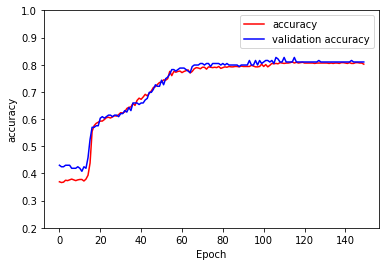

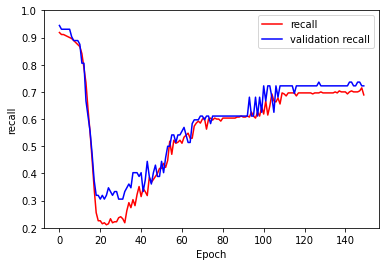

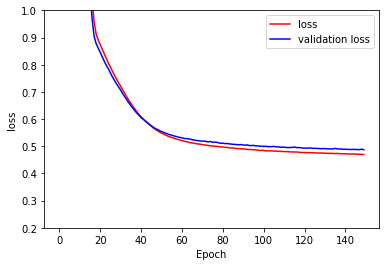

In [15]:
# Hyperparameters.
learning_rate = 0.001
epochs = 150
batch_size = 10

validation_split = 0.2
classification_threshold = 0.5

my_feature = ["Pclass","Feature_Title","Sex","Feature_Age","SibSp","Parch","Feature_Ticket_Number"]

my_label="Survived" 

# Discard any pre-existing version of the model.
my_model = None

# Save previous results
#prev_hist = hist
#prev_epochs = epochs

# Build and Train
my_model = build_model(learning_rate,len(my_feature),classification_threshold)
weight, bias, epochs, hist = train_model(my_model, train_df[my_feature], train_df[my_label], epochs, validation_split)

plot_results(epochs,'accuracy',hist)
plot_results(epochs,'recall',hist)
plot_results(epochs,'loss',hist)

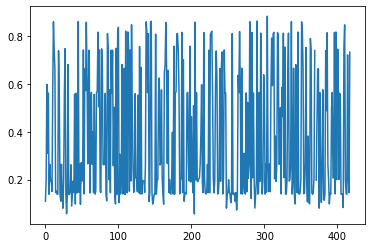

In [17]:
# Predict
plt.plot(my_model.predict(test_df[my_feature]))

In [18]:
# Prepare sumbmission file
prediction_df = test_df[["PassengerId"]].copy()

In [19]:
list_of_list = (my_model.predict(test_df[my_feature]) >= classification_threshold).astype(int).tolist()
survived_list = [item for elem in list_of_list for item in elem]
prediction_df = prediction_df.assign(Survived=survived_list)

In [20]:
prediction_df.to_csv('./deeplearning_submission.csv',index=False,header=True)

In [21]:
example_csv = pd.read_csv('./Data/gender_submission.csv')
prediction_csv = pd.read_csv('./deeplearning_submission.csv')

In [22]:
example_csv.Survived.value_counts(), prediction_csv.Survived.value_counts(), 

(0    266
 1    152
 Name: Survived, dtype: int64,
 0    260
 1    158
 Name: Survived, dtype: int64)